In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import scipy.io as sio
from scipy.sparse.linalg import norm, spsolve, cg
from scipy.sparse import diags

# Data

Load .mat file

In [8]:
G_mat = sio.loadmat('data/G.mat')

In [9]:
X_mat = sio.loadmat('data/x.mat')

In [10]:
H_mat = sio.loadmat('data/H.mat')

Get vectors / matrices

In [11]:
G = G_mat['G']

In [12]:
x = X_mat['x']

In [13]:
H = H_mat['H']

Construct y

In [14]:
M = H.shape[0]

In [15]:
w = np.random.normal(0,1.,(M,1))

In [16]:
y = H.dot(x) + w

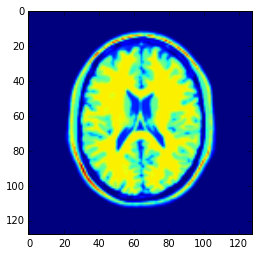

In [11]:
plt.imshow(x.reshape(128,128,order='F'))

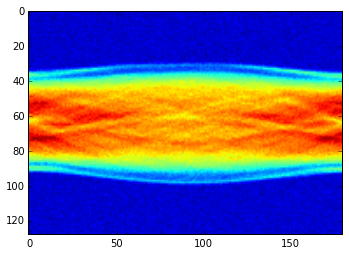

In [12]:
plt.imshow(y.reshape(128,180,order='F'))

# Optimisation problem

Parameters

In [1]:
delta_ = 0.02
lambda_ = 0.13

Tools

In [2]:
def f_gradient(z):
    return H.transpose().dot(H.dot(z) - y)  + lambda_ * G.transpose().dot(np.sqrt(1. + G.dot(z) * G.dot(z) / (delta_ * delta_)))

Lipschitz constant

In [17]:
L = (norm(H)**2) + lambda_ / (delta_ * delta_) * (norm(G)**2)
L

23257671.100093875

# Optimisation algorithms

Gradient descent

In [16]:
x0 = np.zeros((x.shape[0],x.shape[1]))
theta_n = 1. / L

In [17]:
criteria = []
for i in range(500):
    x0 = x0 - theta_n * f_gradient(x0)
    criteria.append(1. / 2. * (np.linalg.norm(H.dot(x0)-y)**2) + lambda_ * np.sum(np.sqrt(1. + G.dot(x0) * G.dot(x0) / (delta_ * delta_))))

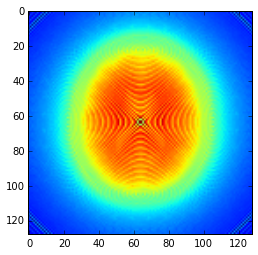

In [18]:
plt.imshow(x0.reshape(128,128,order='F'))

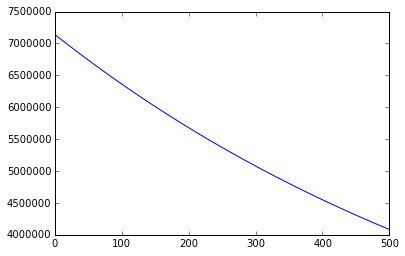

In [19]:
plt.plot(criteria)

MM quadratic algorithm

In [18]:
def omega(z):
    return 1. / (delta_**2) * np.power(1. + z * z / (delta_**2),-1. / 2.)

In [19]:
def A(z):
    diag_ = omega(G.dot(z))
    diag_ = [item for sublist in diag_ for item in sublist]
    return H.transpose().dot(H) + lambda_ * G.transpose().dot(diags(diag_,0)).dot(G)

In [20]:
xn = np.zeros((x.shape[0],x.shape[1]))
theta_n = 1.
for i in range(3):
    # dn = spsolve(A(xn),f_gradient(xn)) -> KILL KERNEL
    dn = cg(A(xn),f_gradient(xn))
    if dn[1] != 0:
        print '/!\ inversion failed'
    arr_ = np.zeros((x.shape[0],x.shape[1]))
    arr_[:,0] = dn[0][:]
    xn = xn - theta_n * arr_

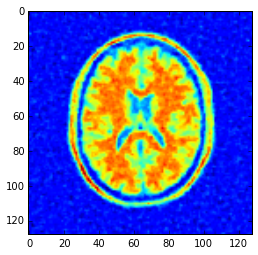

In [21]:
plt.imshow(xn.reshape(128,128,order='F'))

3MG algorithm

In [27]:
xn = np.zeros((x.shape[0],x.shape[1]))
xn_1 = np.zeros((x.shape[0],x.shape[1]))
theta_n = 1.
for i in range(5):
    dxn = f_gradient(xn)
    D_k = np.concatenate((-dxn,xn-xn_1),axis=1)
    uk_1 = np.dot(np.transpose(D_k),A(xn).dot(D_k))
    uk_2 = np.dot(np.transpose(D_k),dxn)
    uk = -np.dot(np.linalg.pinv(uk_1),uk_2)
    xn_1 = xn
    xn = xn + np.dot(D_k,uk)

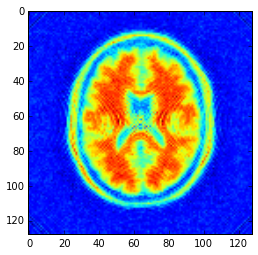

In [28]:
plt.imshow(xn.reshape(128,128,order='F'))